# 3. Simulating CRN
This tutorial has been adapted from the Catalyst.jl [docs](https://docs.sciml.ai/Catalyst/stable/introduction_to_catalyst/catalyst_for_new_julia_users/).

In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Documents/repos/JuliaTutorials`


In [1]:
using Catalyst
using OrdinaryDiffEq
using Plots
using Latexify

## Example 1: Birth-death process

In [2]:
rn = @reaction_network begin
    b, 0 --> X
    d, X --> 0
end

Model ##ReactionSystem#237:
Unknowns (1): see unknowns(##ReactionSystem#237)
  X(t)
Parameters (2): see parameters(##ReactionSystem#237)
  b
  d

In [3]:
# Alternative construction
rxns = [
    @reaction b, 0 --> X
    @reaction d, X --> 0
]
rn2 = ReactionSystem(rxns, name=:rn2)

Model rn2:
Unknowns (1): see unknowns(rn2)
  X(t)
Parameters (2): see parameters(rn2)
  b
  d

In [4]:
latexify(rn, form=:ode)

L"$\begin{align}
\frac{\mathrm{d} X\left( t \right)}{\mathrm{d}t} &= b - d X\left( t \right)
\end{align}
$"

In [5]:
# Initial conditions
u0 = [:X => 1.0]
# parameter values
params = [:b => 1.0, :d => 0.2]
# Simulation timespan
tspan = (0.0, 10.0)

(0.0, 10.0)

Note the `:` in front of `:X` indicates this is a Julia *Symbol*.

In [6]:
oprob = ODEProblem(rn, u0, tspan, params)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
Initialization status: FULLY_DETERMINED
Non-trivial mass matrix: false
timespan: (0.0, 10.0)
u0: 1-element Vector{Float64}:
 1.0

In [7]:
sol = solve(oprob)
sol[:X]

8-element Vector{Float64}:
 1.0
 1.0827989176094226
 1.5485226736963285
 2.2516776896410655
 2.94349883404974
 3.586196656299412
 4.105252550819238
 4.458655579198203

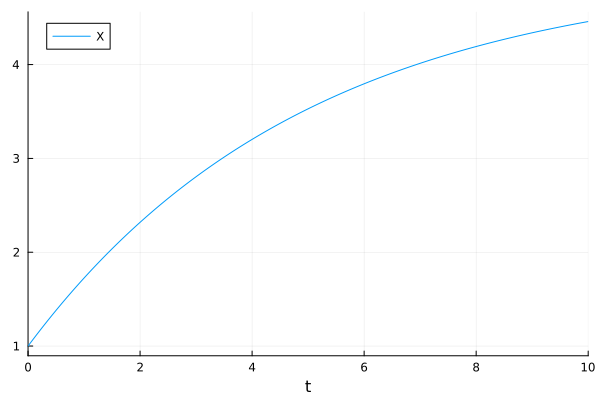

In [8]:
plot(sol)

## Example 2: SIR model

In [9]:
sir_model = @reaction_network SIR begin
    b, S + I --> 2I
    k, I --> R
end

Model SIR:
Unknowns (3): see unknowns(SIR)
  S(t)
  I(t)
  R(t)
Parameters (2): see parameters(SIR)
  b
  k

In [10]:
u0 = [:S => 50, :I => 1, :R => 0]
tspan = (0.0, 10.0)
params = [:b => 0.2, :k => 1.0]

2-element Vector{Pair{Symbol, Float64}}:
 :b => 0.2
 :k => 1.0

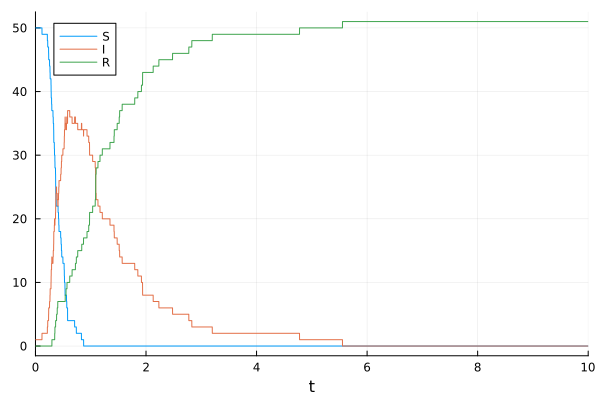

In [11]:
jinput = JumpInputs(sir_model, u0, tspan, params)
jprob = JumpProblem(jinput)

sol = solve(jprob)
plot(sol)

## Example 3: Repressilator

In [13]:
rn = @reaction_network Repressilator begin
    hillr(P₃,α,K,n), ∅ --> m₁
    hillr(P₁,α,K,n), ∅ --> m₂
    hillr(P₂,α,K,n), ∅ --> m₃
    (δ,γ), m₁ <--> ∅
    (δ,γ), m₂ <--> ∅
    (δ,γ), m₃ <--> ∅
    β, m₁ --> m₁ + P₁
    β, m₂ --> m₂ + P₂
    β, m₃ --> m₃ + P₃
    μ, P₁ --> ∅
    μ, P₂ --> ∅
    μ, P₃ --> ∅
end

Model Repressilator:
Unknowns (6): see unknowns(Repressilator)
  m₁(t)
  m₂(t)
  m₃(t)
  P₁(t)
  ⋮
Parameters (7): see parameters(Repressilator)
  α
  K
  n
  δ
  ⋮

In [14]:
@show species(rn)
@show parameters(rn)

species(rn) = SymbolicUtils.BasicSymbolic{Real}[m₁(t), m₂(t), m₃(t), P₁(t), P₂(t), P₃(t)]
parameters(rn) = Any[α, K, n, δ, γ, β, μ]


7-element Vector{Any}:
 α
 K
 n
 δ
 γ
 β
 μ

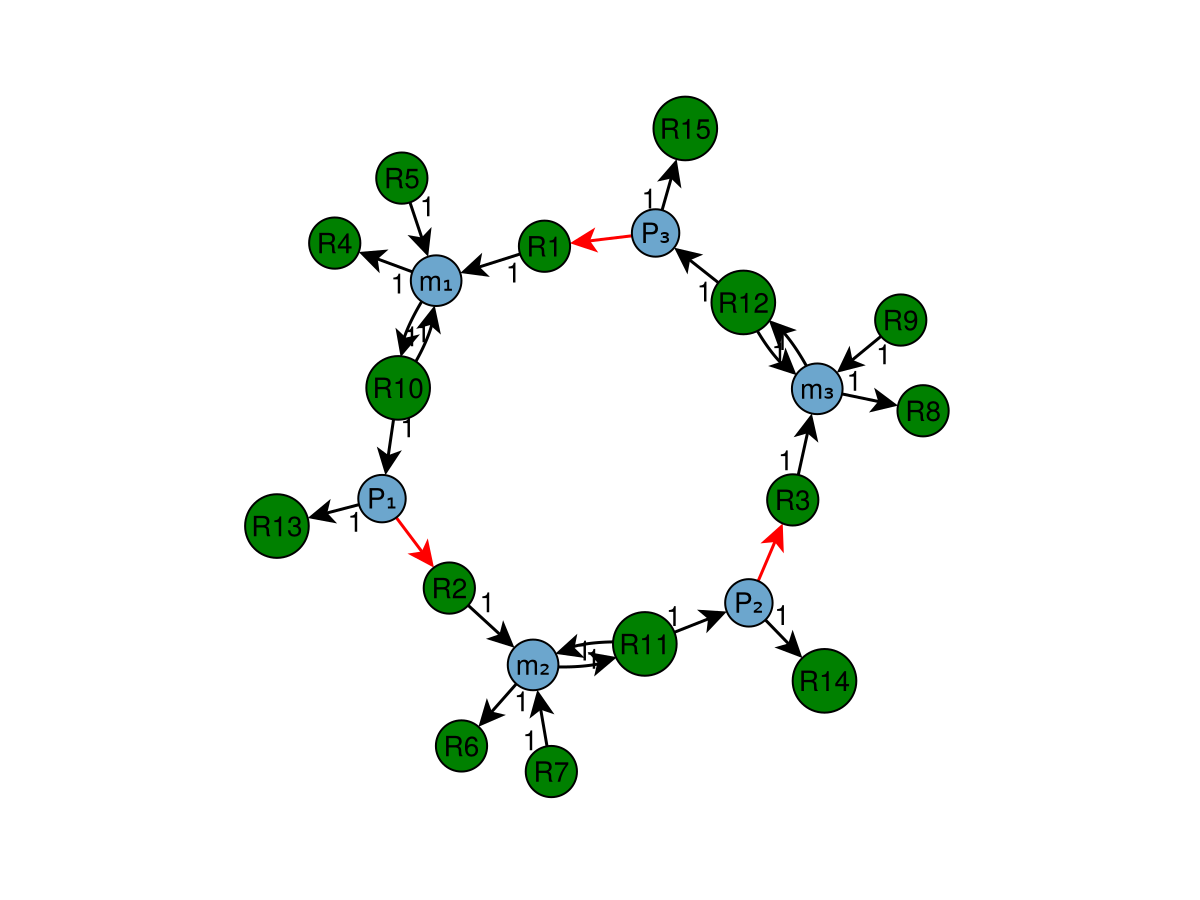

In [15]:
import CairoMakie, GraphMakie, NetworkLayout
g = plot_network(rn)

In [ ]:
# Optional
# save("repressilator_graph.png", g)

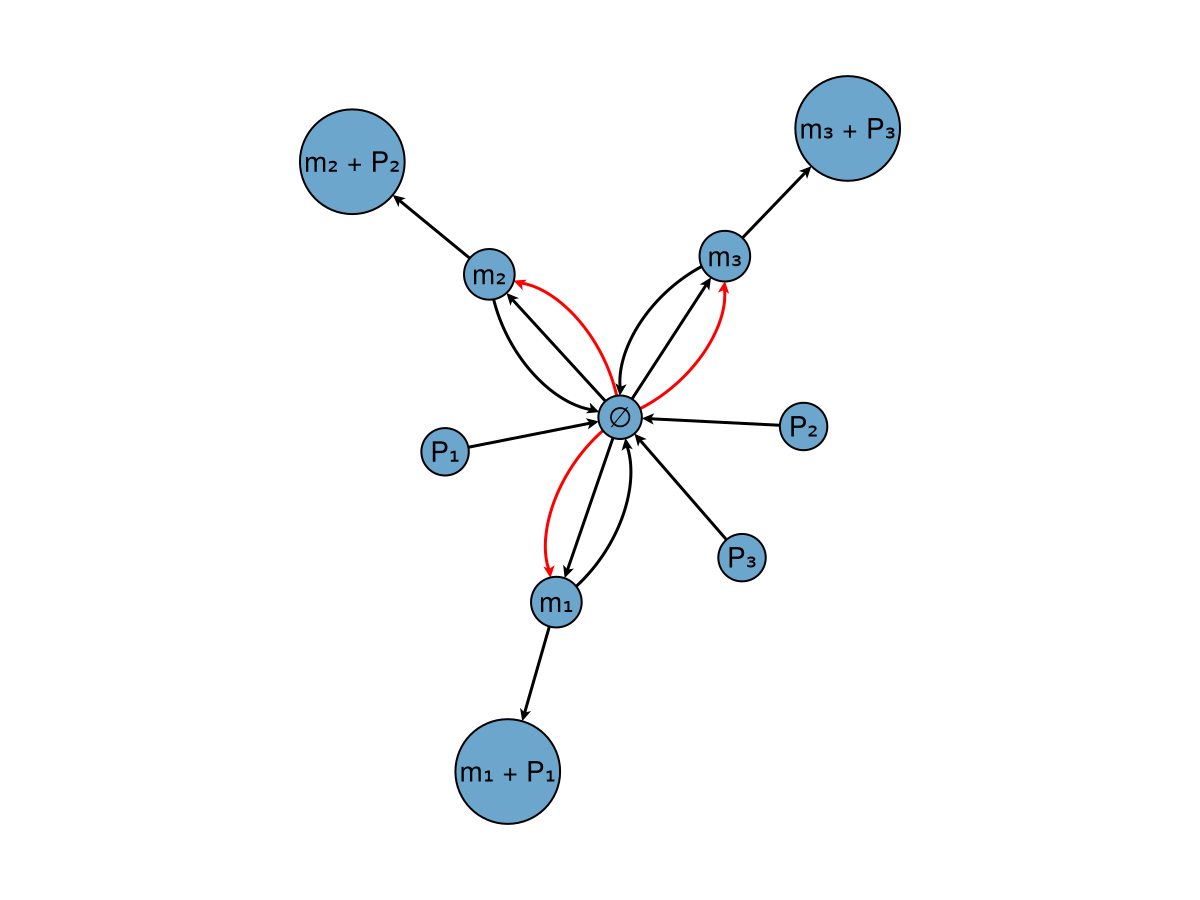

In [17]:
plot_complexes(rn)

In [18]:
odesys = convert(ODESystem, rn)

Model Repressilator:
Equations (6):
  6 standard: see equations(Repressilator)
Unknowns (6): see unknowns(Repressilator)
  m₁(t)
  m₂(t)
  m₃(t)
  P₁(t)
  ⋮
Parameters (7): see parameters(Repressilator)
  α
  K
  n
  δ
  ⋮

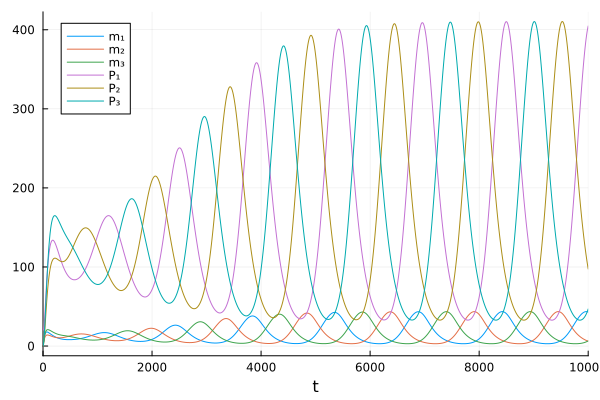

In [19]:
pmap  = (:α => .5, :K => 40, :n => 2, :δ => log(2)/120,
         :γ => 5e-3, :β => log(2)/6, :μ => log(2)/60)
u₀map = [:m₁ => 0., :m₂ => 0., :m₃ => 0., :P₁ => 20., :P₂ => 0., :P₃ => 0.]

# time interval to solve on
tspan = (0., 10000.)

# create the ODEProblem we want to solve
oprob = ODEProblem(rn, u₀map, tspan, pmap)

sol = solve(oprob, Tsit5(), saveat=10.0)
plot(sol)